In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
model_path = os.path.join(base_path, "model_runs")
fig_dir_path = os.path.join(model_path, "figs") 

In [4]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
# target_rate_dt = 0.001  # 0.0001
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

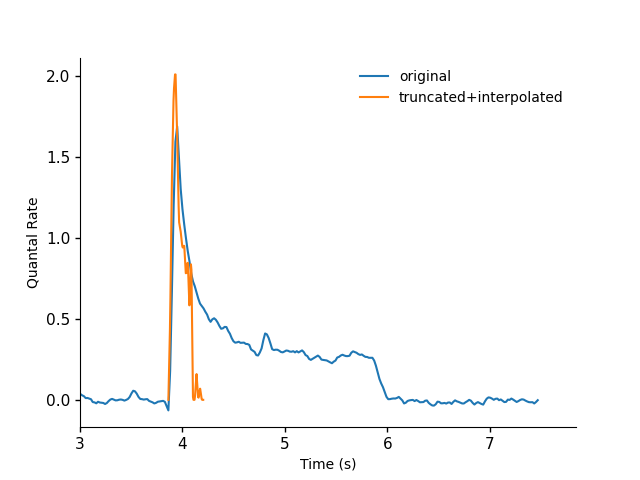

In [5]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="truncated+interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [6]:
save_name = "somaNa_0p3_etau3_x0p6w_itau6_x0p8w_6n_1tr"
# save_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2_plex3"
# save_name = "decr_conf_5ms_step_weight_x2_plex3"
# save_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2_plex3"
# save_name = "decr_conf_5ms_step_weight_x2_sac_20um_rho_range_6n_3tr"
# save_name = "decr_conf_5ms_step_weight_x2_sac_50um_6n_3tr"

load_name = None
# load_name = "test"
# load_name = "decr_conf_5ms_step_weight_x2"
# load_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2"
# load_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2_plex3"
# load_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2_rho_range_6n_3tr"
# load_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2_rho_range_6n_3tr_plex3"
# load_name = "etau3_x0p6w_itau6_x0p8w_6n_1tr"

# model_config = configs.conf(
model_config = configs.decr_weight(
# model_config = configs.alt_conf(
# model_config = configs.alt_conf_2(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    # poisson_rates={"sac": vrate * 1., "glut": vrate * 1., "dt": target_rate_dt},
    poisson_rates={"sac": vrate * 0.5, "glut": vrate * 1., "dt": target_rate_dt},
    # plexus=3,
    # plexus_share=0.5,
    plexus=0,
    plexus_share=None,
    stacked_plex=False,
)

# TODO: what about decreasing rate further to allow for greated weights with these longer taus?
# also, is 3 and 6 appropriate for ACh and GABA respectively? 
model_config["synprops"]["E"]["weight"] = model_config["synprops"]["E"]["weight"]      *0.6# * 0.5 #* 2 # CHANGED!
model_config["synprops"]["PLEX"]["weight"] = model_config["synprops"]["PLEX"]["weight"]*0.6# * 0.5 #* 2 # CHANGED!
model_config["synprops"]["I"]["weight"] = model_config["synprops"]["I"]["weight"]      * 0.8 #* 2 # CHANGED!
# model_config["synprops"]["E"]["tau2"] = 0.54
# model_config["synprops"]["PLEX"]["tau2"] = 0.54
# model_config["synprops"]["E"]["tau2"] = 1.5  # CHANGED!
# model_config["synprops"]["PLEX"]["tau2"] = 1.5  # CHANGED!
# model_config["synprops"]["E"]["tau2"] = 4  # CHANGED!
# model_config["synprops"]["PLEX"]["tau2"] = 4  # CHANGED!
model_config["synprops"]["E"]["tau2"] = 3  # CHANGED!
model_config["synprops"]["PLEX"]["tau2"] = 3  # CHANGED!
model_config["synprops"]["I"]["tau2"] = 6  # CHANGED!
# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0

# model_config["dend_Na"] = 0.02
# model_config["dend_K"] = 0.02
# model_config["dend_Na"] = 0.015
# model_config["dend_K"] = 0.01
# model_config["soma_Na"] = 0.4
# model_config["soma_Na"] = 0.3  # CHANGED!
    
# model_config["sac_offset"] = 30

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    t0 = time.time()
    exps.sacnet_rho_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=1,
        rho_steps=[0.0, 1.],
        # rho_steps=[1.],
        # rho_steps=[0.9],
        # rho_steps=[0., 0.4, 0.8, 0.85, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 1.],
        pool_sz=6,
    )
    print("time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)

rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", list(d[rhos[0]][idxs[0]].keys()))

Running with rho = 0.00
  sac net trials 1 to 6 (of 6)...
Running with rho = 1.00
  sac net trials 1 to 6 (of 6)...
Done!
time: 291.89780354499817
==keys==
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5]
exp keys: ['dendrites', 'metrics', 'params', 'sac_net', 'soma', 'syn_locs']


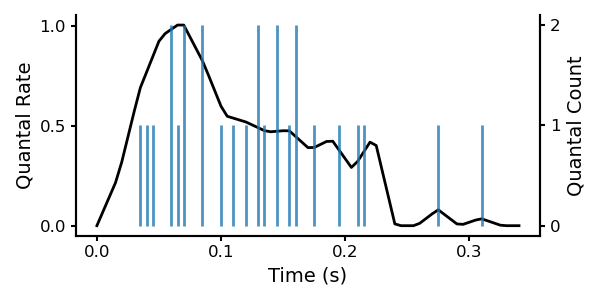

In [7]:
rng = np.random.default_rng()
xaxis = np.arange(len(vrate)) * target_rate_dt

qrate = vrate * 0.5
# qrate = vrate / np.max(vrate)
release_fig, release_ax = plt.subplots(1, figsize=(6, 3))
quanta_ax = release_ax.twinx()
release_ax.plot(xaxis, qrate, lw=2, c="black")
release_ax.set_ylabel("Quantal Rate", fontsize=14)
rpq = deconv.poisson_of_release(rng, qrate)
_, quanta_stems, _ = quanta_ax.stem(
    xaxis,
    rpq,
    linefmt="-",
    markerfmt="none",
    basefmt="none",
)
quanta_stems.set_alpha(0.8)
quanta_stems.set_linewidth(2.)
# quanta_stems.set_color("black")
release_ax.set_yticks([0, 0.5, 1])
quanta_ax.set_yticks(np.arange(rpq.max() + 1))
release_ax.set_xticks([0, 0.1, 0.2, 0.3])
quanta_ax.set_ylabel("Quantal Count", fontsize=14)
release_ax.set_xlabel("Time (s)", fontsize=14)
clean_axes([release_ax, quanta_ax], ticksize=12, spine_width=1.5, remove_spines=["top"])
release_fig.tight_layout()
for ext in [".svg", ".png"]:
    release_fig.savefig(os.path.join(fig_path, "poisson_quanta_ex" + ext), bbox_inches="tight")

In [8]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [9]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-56)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)

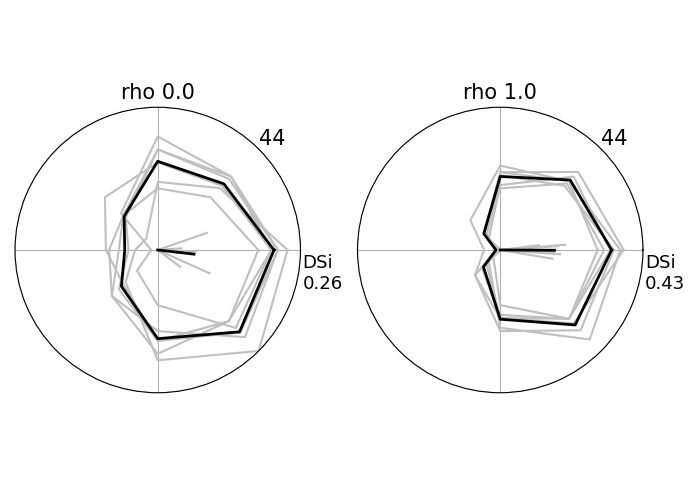

In [10]:
show_rhos = list(metrics.keys())
show_rhos = [0.0, 1.0]
# show_rhos = [0.0, 0.9, 0.96, 0.99, 1.0]
# show_rhos = [0.0, 0.9, 0.96, 1.0]
max_spikes = np.max([metrics[r]["spikes"] for r in show_rhos])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(show_rhos)
polar_ax = [
    polar_plot(
        metrics[r],
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, r in enumerate(show_rhos)
]
polar_fig.tight_layout()

rho_lbl = str(show_rhos)[1:-1].replace(", ", "_").replace(".", "p")
for ext in [".png", ".svg"]:
    polar_fig.savefig(os.path.join(fig_path, "polar_%s%s" % (rho_lbl, ext)), bbox_inches="tight")

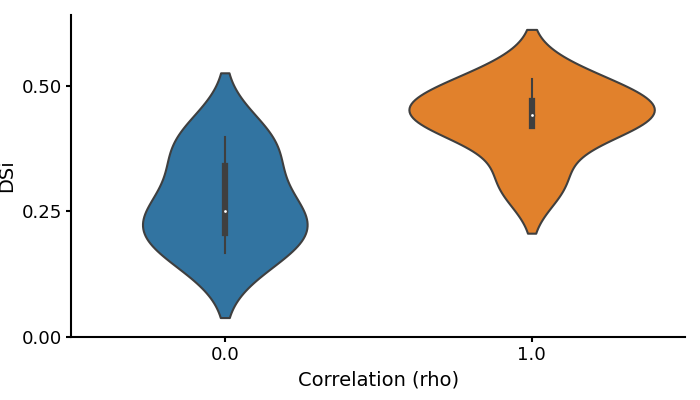

In [11]:
show_rhos = list(metrics.keys())
# show_rhos = [0.0, 1.0]
show_spks = [135, 180, 225]
show_spks = []
show_metrics = {r: metrics[r] for r in show_rhos}
rho_violin_fig, rho_violin_ax = sac_rho_violins(
    show_metrics,
    dir_labels,
    show_spks=show_spks,
    share_ymax=True,
    figsize=(5, 8) if len(show_spks) == 3 else None if len(show_spks) else (7, 4)
)
rho_violin_ax[0].set_yticks([0, 0.25, 0.5])
clean_axes(rho_violin_ax, spine_width=1.5, ticksize=13)

for ext in [".png", ".svg"]:
    spk_lbl = ("_spks_" + "_".join(show_spks)) if len(show_spks) else ""
    rho_violin_fig.savefig(os.path.join(fig_path, "violins" + spk_lbl + ext), bbox_inches="tight")

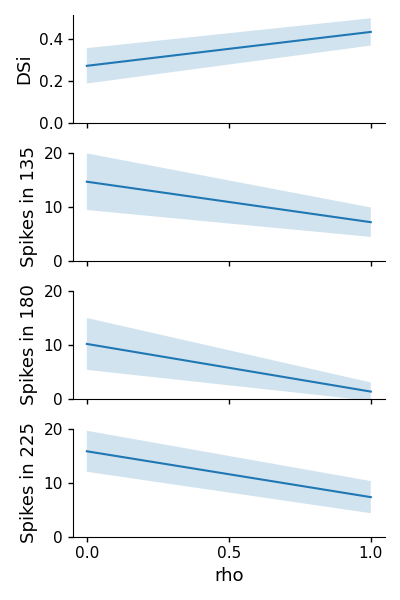

In [12]:
share_spk_ymax = True

rho_dsis = np.stack([metrics[r]["DSis"] for r in rhos], axis=0)
rho_dsis_flat = rho_dsis.reshape(len(rhos), -1)
rho_net_avg_dsis = np.mean(rho_dsis, axis=2)
rho_net_std_dsis = np.std(rho_net_avg_dsis, axis=1)
rho_spks = np.stack([metrics[r]["spikes"].transpose(2, 0, 1) for r in rhos], axis=0)
rho_net_avg_spks = np.mean(rho_spks, axis=3)
rho_net_std_spks = np.std(rho_net_avg_spks, axis=2)
rho_avg_dsis = np.array([np.mean(metrics[r]["avg_DSi"]) for r in rhos])
rho_avg_spks = np.stack([np.mean(metrics[r]["spikes"], axis=(0, 1)) for r in rhos], axis=0)
spk_ylim = np.max(rho_avg_spks[:, [6, 7, 0]] + rho_net_std_spks[:, [6, 7, 0]])
spk_maxtick = np.round(spk_ylim) if np.round(spk_ylim) % 2 == 0 else np.round(spk_ylim) + 1 
spk_yticks = [0, spk_maxtick // 2, spk_maxtick]

def rho_plot_dir(row, dir_idx):
    rho_range_ax[row].fill_between(
        rhos,
        rho_avg_spks[:, dir_idx] + rho_net_std_spks[:, dir_idx],
        rho_avg_spks[:, dir_idx] - rho_net_std_spks[:, dir_idx],
        alpha=0.2,
    )
    rho_range_ax[row].plot(rhos, rho_avg_spks[:, dir_idx])
    rho_range_ax[row].set_ylabel("Spikes in %i" % dir_labels[dir_idx], fontsize=13)
    if share_spk_ymax:
        rho_range_ax[row].set_ylim(0, spk_ylim)
        rho_range_ax[row].set_yticks(spk_yticks)
    
rho_range_fig, rho_range_ax = plt.subplots(4, sharex=True, figsize=(4, 6))
rho_range_ax[0].fill_between(
    rhos,
    rho_avg_dsis + rho_net_std_dsis,
    rho_avg_dsis - rho_net_std_dsis,
    alpha=0.2,
)
rho_range_ax[0].plot(rhos, rho_avg_dsis)
rho_plot_dir(1, 6) # 135
rho_plot_dir(2, 7) # 180
rho_plot_dir(3, 0) # 225
rho_range_ax[0].set_ylabel("DSi", fontsize=13)
rho_range_ax[-1].set_xlabel("rho", fontsize=13)
rho_range_ax[-1].set_xticks([0, 0.5, 1.])
rho_range_ax[0].set_yticks([0, 0.2, 0.4])
clean_axes(rho_range_ax)
rho_range_fig.tight_layout()

for ext in [".png", ".svg"]:
    rho_range_fig.savefig(os.path.join(fig_path, "rho_range" + ext), bbox_inches="tight")

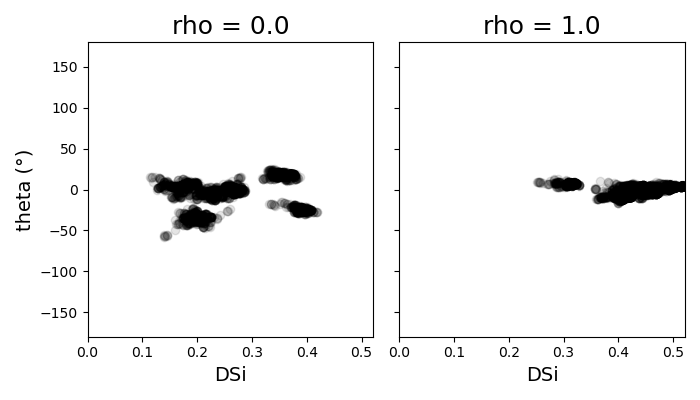

In [13]:
show_rhos = list(metrics.keys())
show_rhos = [0.0, 1.0]
show_tuning = {r: tuning[r] for r in show_rhos}
scatter_fig = ds_scatter(show_tuning, figsize=(7, 4))
scatter_fig.tight_layout()

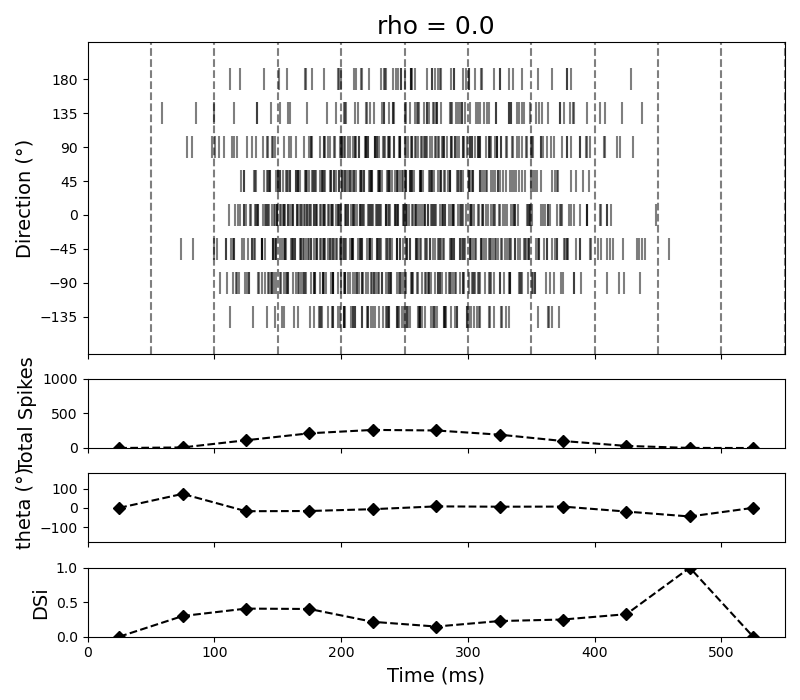

In [14]:
dir_field_offsets = [10.9, 25.7, 36.4, 22.5, 6.6, 5.6, 1.1, 0.]  # ms
rho = 0. 
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=rho,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=1000,
    figsize=(8, 7),
)
name = os.path.join(fig_path, "rasters_%s" % ("%.2f" % rho).replace(".", "p"))
for ext in [".png", ".svg"]:
    rasters_fig.savefig(name + ext, bbox_inches="tight")

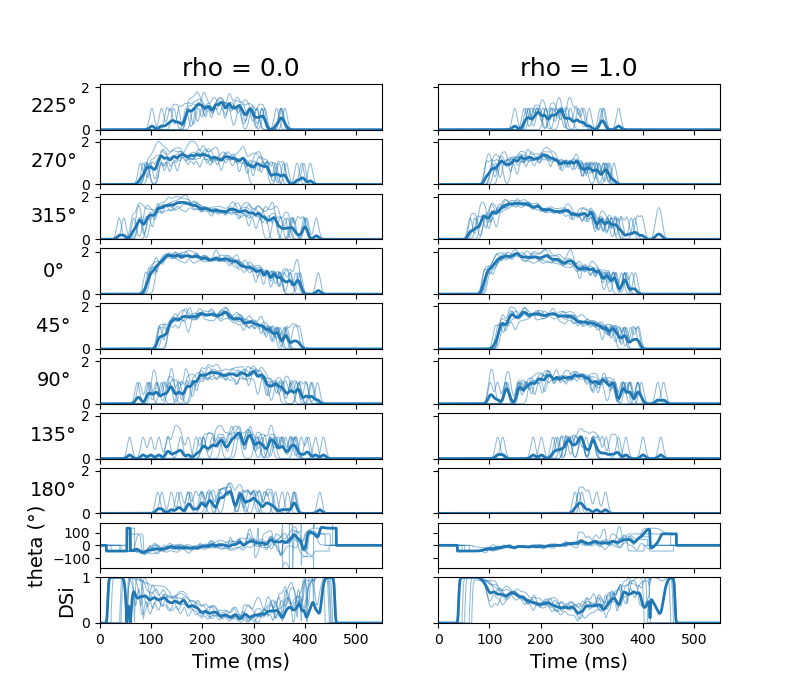

In [15]:
evol = time_evolution(d, dir_labels, rhos=[0.0, 1.0], kernel_var=45, figsize=(8, 7))
evol.savefig(os.path.join(fig_path, "evolution.png"), bbox_inches="tight")
evol.savefig(os.path.join(fig_path, "evolution.svg"), bbox_inches="tight")

In [16]:
rho = 1.0
if d[rho][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rec_locs = d[rho][0]["dendrites"]["locs"]
    syn_locs = d[rho][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[rho])
    theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[rho])

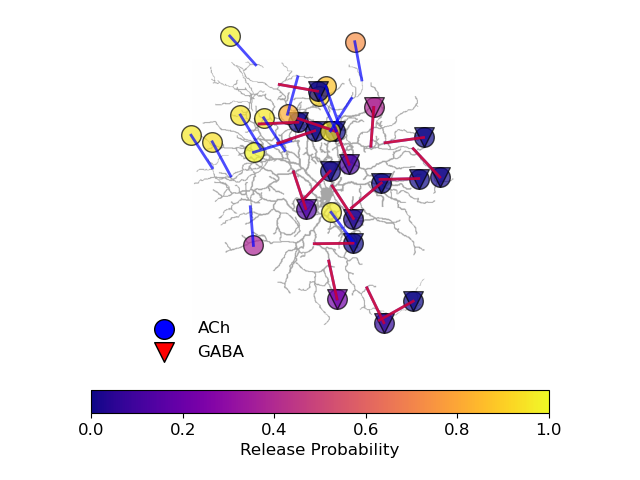

In [17]:
rho = 1.
net = 0
stim_angle = 0
n_syn = 30
seed = 13
show_plex = True

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=stim_angle,
    n_syn=n_syn,
    sac_thickness=2,
    sac_marker_size=200,
    syn_choice_seed=seed,
    show_plex=show_plex,
    # ach_color="green",
    # gaba_color="cyan",
    ach_color="blue",
    gaba_color="red",
    ach_edge="black",
    gaba_edge="black",
    # ach_edge="blue",
    # gaba_edge="red",
)
#6 26 37
over_fig.tight_layout()

if 1:
    for ext in [".png", ".svg"]:
        name = "sac_net_rho%s_net%i_dir%i_n%i_seed%i%s%s" % (
            str(rho).replace(".", "p"),
            net,
            stim_angle,
            n_syn,
            seed,
            "_plex" if show_plex and "PLEX" in d[rho][net]["sac_net"]["wiring"]["bp_locs"] else "",
            ext
        )
        over_fig.savefig(os.path.join(fig_path, name))

Average GABA synapse count: 172.24


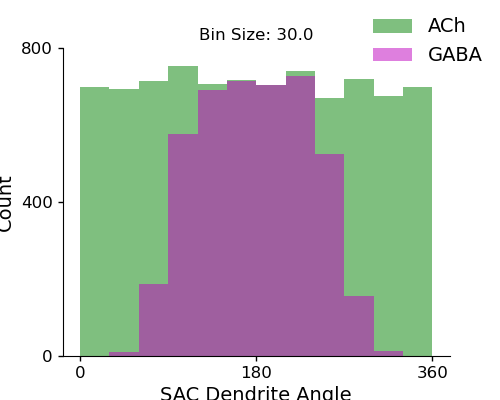

In [18]:
conf = copy.deepcopy(model_config)
conf["seed"] = 4
hist_nets = 25

angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    conf, n_nets=hist_nets, bins=[12], incl_yticks=True, figsize=(5, 4))

for ax in angle_dist_ax:
    ax.set_xticks([0, 180, 360])
    ax.patch.set_alpha(0)

ymin, ymax = ax.get_ybound()
n = n_digits(ymax)
i = 10 ** (n - 1)
if ymax % i != 0:
    ymax = i * (ymax // i + 1)

max_tick = ymax if ymax % 2 == 0 else ymax + 1
ax.set_ylim(0, ymax)
ax.set_yticks([0, max_tick // 2, max_tick])

name = os.path.join(fig_path, "angle_hist_seed%i_%inets" % (conf["seed"], hist_nets))
for ext in [".png", ".svg"]:
    angle_dist_fig.savefig(name + ext, bbox_inches="tight")

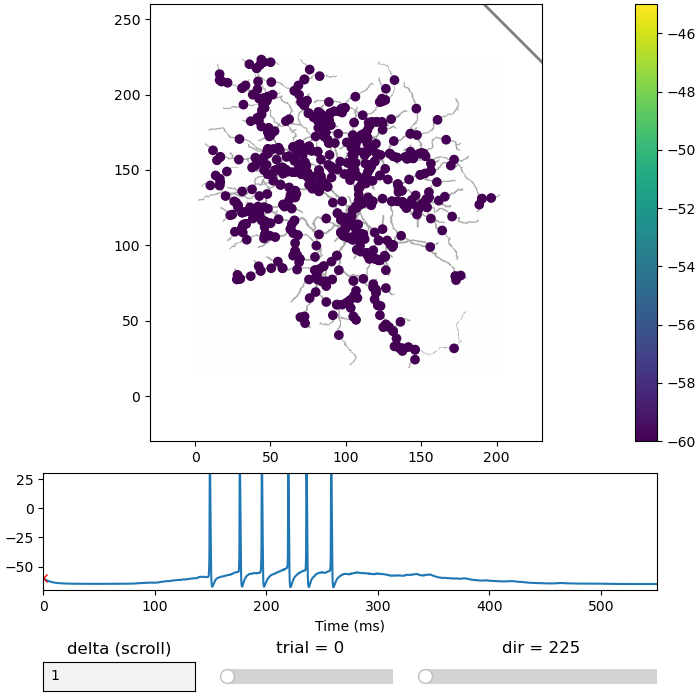

In [19]:
rho = 1.0
net = 1
mr = MotionResponse(
    d[rho][net], 
    tree_k="Vm",
    figsize=(7, 7), 
    tree_vmin=-60,
    tree_vmax=-45,
)

In [20]:
if 1:
    name = "motion_%s_rho%s_net%i_tr%i_dir%i_%sms.svg" % (
        mr.tree_k,
        str(rho).replace(".", "p"),
        net,
        mr.trial_idx,
        mr.dirs[mr.dir_idx],
        str(round(mr.time[mr.tree_t * mr.rate_diff], 2)).replace(".", "p")
    )
    mr.fig.savefig(os.path.join(fig_path, name))

In [21]:
close_button()

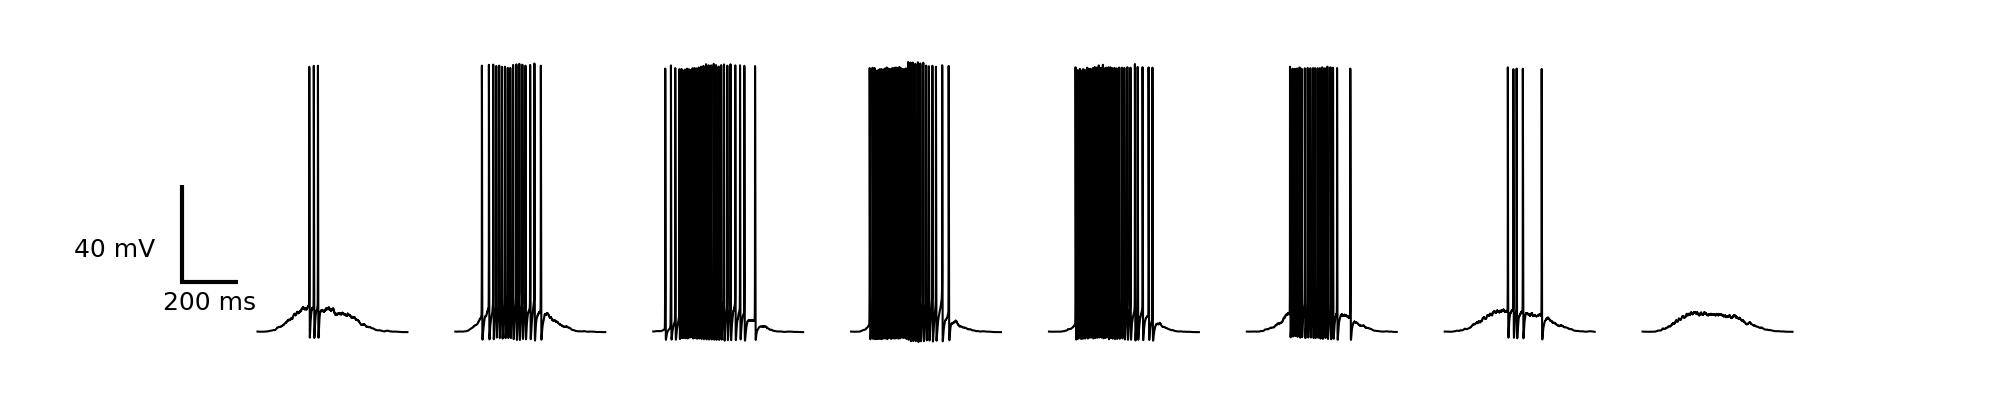

In [22]:
rho = 1.0
net = 0
trial = 0

vm_pts = d[rho][net]["soma"]["Vm"].shape[-1]
vm_xaxis = np.linspace(0, vm_pts * d[rho][net]["params"]["dt"], vm_pts)

trial_vm_fig, trial_vm_ax = plt.subplots(1, len(dir_labels), sharex=True, sharey=True, figsize=(20, 4))
for i in range(len(dir_labels)):
    trial_vm_ax[i].plot(vm_xaxis[300:], d[rho][net]["soma"]["Vm"][trial, i, 300:], c="black")
    trial_vm_ax[i].patch.set_alpha(0)

clean_axes(trial_vm_ax, remove_spines=["left", "right", "top", "bottom"])

sizex = 200
sizey = 40
add_scalebar(
    trial_vm_ax[0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

name = os.path.join(fig_path, "vm_rho%s_net%i_trial%i" % (("%.2f" % rho).replace(".", "p"), net, trial))
for ext in [".png", ".svg"]:
    trial_vm_fig.savefig(name + ext)